In [ ]:
# Installing the required packages
!pip install tensorflow
!pip install tensorflow-datasets

# **Importing the required Libraries**

In [ ]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Conv1D, GlobalMaxPooling1D, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# **Importing the Dataset from IMDB**

In [ ]:
# Loading IMDB dataset using TensorFlow Datasets
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.UPVTLH_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.UPVTLH_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.UPVTLH_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# Converting TensorFlow Dataset to pandas DataFrame for analysis
def dataset_to_dataframe(dataset):
    reviews = []
    labels = []
    for review, label in dataset:
        reviews.append(review.numpy().decode('utf-8'))
        labels.append(label.numpy())
    return pd.DataFrame({'review': reviews, 'sentiment': labels})

train_df = dataset_to_dataframe(train_dataset)
test_df = dataset_to_dataframe(test_dataset)

In [ ]:
# Combining train and test for full analysis of data
full_df = pd.concat([train_df, test_df])

In [ ]:
full_df.info()
full_df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


,sentiment
count,50000.000000
mean,0.500000
std,0.500005
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [ ]:
full_df["review"][3]

,review
3,This is the kind of film for a snowy Sunday af...
3,Poor Shirley MacLaine tries hard to lend some ...


# **Dataset Exploration**

In [ ]:
print("Overall Dataset Overview")
print(f"Total reviews=====> {len(full_df)}")
print(f"Positive reviews=====> {full_df.sentiment.value_counts()[1]} ({full_df.sentiment.value_counts(normalize=True)[1]:.1%})")
print(f"Negative reviews=====> {full_df.sentiment.value_counts()[0]} ({full_df.sentiment.value_counts(normalize=True)[0]:.1%})\n")

Overall Dataset Overview
Total reviews=====> 50000
Positive reviews=====> 25000 (50.0%)
Negative reviews=====> 25000 (50.0%)



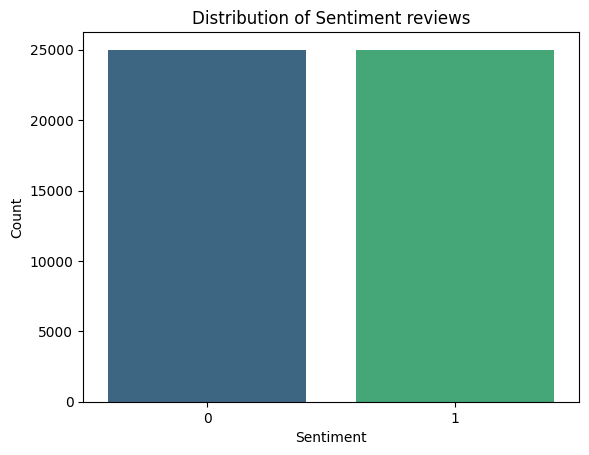

In [ ]:
sns.countplot(x='sentiment', data=full_df, hue='sentiment', palette='viridis', legend=False)
plt.title('Distribution of Sentiment reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

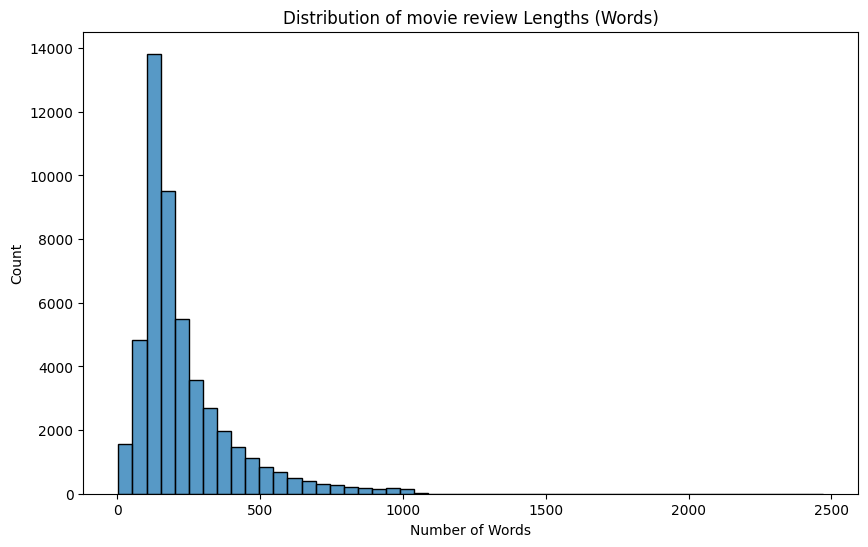

In [ ]:
# Visualizing the movie review length distribution
review_lengths = full_df['review'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(review_lengths, bins=50)
plt.title('Distribution of movie review Lengths (Words)')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.show()

# **Data Preprocessing**

In [ ]:
# Data Preprocessing
def preprocess_text(text):
# Clean text data by, Removing HTML tags, Removing special characters, Converting to lowercase
    text = tf.strings.regex_replace(text, "<[^>]+>", "")
    text = tf.strings.regex_replace(text, "[^a-zA-Z]", " ")
    text = tf.strings.lower(text)
    return text

In [ ]:
X = []
sentences = list(full_df['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

X[3]

<tf.Tensor: shape=(), dtype=string, numpy=b'this is the kind of film for a snowy sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm chair and mellow for a couple of hours  wonderful performances from cher and nicolas cage  as always  gently row the plot along  there are no rapids to cross  no dangerous waters  just a warm and witty paddle through new york life at its best  a family film in every sense and one that deserves the praise it received '>

In [ ]:
# Convert the labels into numbers
y = full_df['sentiment']

# Represent 'positive' with the number 1 and 'negative' with the number 0
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [ ]:
# Apply preprocessing
max_words = 10000
max_length = 200

In [ ]:
# Creating the tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['review'])

In [ ]:
# Converting the text to sequences
train_sequences = tokenizer.texts_to_sequences(train_df['review'])
test_sequences = tokenizer.texts_to_sequences(test_df['review'])

In [ ]:
# Padding sequences
X_train = pad_sequences(train_sequences, maxlen=max_length)
X_test = pad_sequences(test_sequences, maxlen=max_length)
y_train = train_df['sentiment']
y_test = test_df['sentiment']

In [ ]:
# Vocabulary size along with +1 for padding
vocab_size = len(tokenizer.word_index) + 1

# **Embedding Layer with GloVe**

In [ ]:
# Download GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip


--2025-02-27 01:53:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-02-27 01:53:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-02-27 01:53:12--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

gl

In [ ]:
# Loading the GloVe embeddings
embedding_dim = 100
embeddings_index = {}

with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [ ]:
# Create embedding matrix
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = tf.keras.layers.Embedding(
    input_dim=max_words,
    output_dim=embedding_dim,
    weights=[embedding_matrix],  # Load pre-trained weights
    trainable=False
)

# **Bidirectional Long Short Term Memory (LSTM)**

In [ ]:
# If I have referred to LSTM in the following upcoming cells, it specifically refers to the Bidirectional LSTM. I have used 'LSTM' in some places for simplicity.
def build_lstm_model():
    model = Sequential([
        Embedding(input_dim=max_words,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  input_length=max_length,
                  trainable=False),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(32)),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])
    return model


In [ ]:
# Initializing the LSTM model
lstm_model = build_lstm_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# LSTM model summary
print("Bidirectional LSTM Model Summary")
lstm_model.summary()

Bidirectional LSTM Model Summary


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

# **Bidirectional LSTM Training**

In [ ]:
# Training parameters
batch_size = 128
epochs = 8
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
# Training the LSTM model
print("Training Bi LSTM Model")
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Training Bi LSTM Model
Epoch 1/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 108s 652ms/step - accuracy: 0.5741 - loss: 1.1079 - precision: 0.5752 - recall: 0.5520 - val_accuracy: 0.7334 - val_loss: 0.6516 - val_precision: 0.7036 - val_recall: 0.8179
Epoch 2/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 145s 669ms/step - accuracy: 0.7409 - loss: 0.6110 - precision: 0.7319 - recall: 0.7553 - val_accuracy: 0.7716 - val_loss: 0.5062 - val_precision: 0.7245 - val_recall: 0.8854
Epoch 3/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 152s 729ms/step - accuracy: 0.7951 - loss: 0.4855 - precision: 0.7944 - recall: 0.7931 - val_accuracy: 0.8094 - val_loss: 0.4300 - val_precision: 0.7859 - val_recall: 0.8570
Epoch 4/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 132s 668ms/step - accuracy: 0.8186 - loss: 0.4285 - precision: 0.8195 - recall: 0.8143 - val_accuracy: 0.8080 - val_loss: 0.4177 - val_precision: 0.7568 - val_recall: 0.9147
Epoch 5/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 142s 669ms/step - accuracy: 0.8286 - loss: 0.3971 - precision: 0.8265 - recall: 0.8301

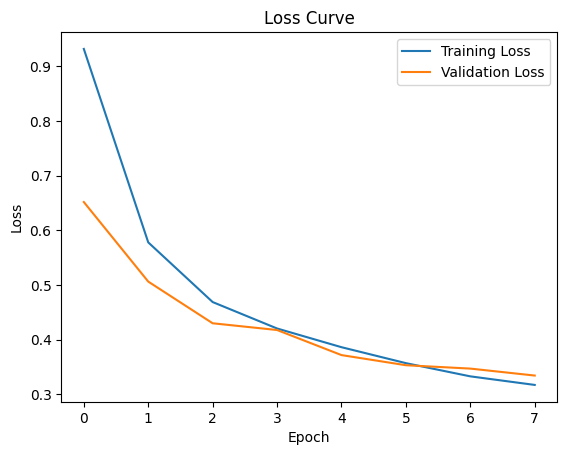

In [ ]:
#Plotting the Loss Curve of LSTM
def plot_loss_curve(lstm_history):
    plt.plot(lstm_history.history['loss'], label="Training Loss")
    plt.plot(lstm_history.history['val_loss'], label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

plot_loss_curve(lstm_history)

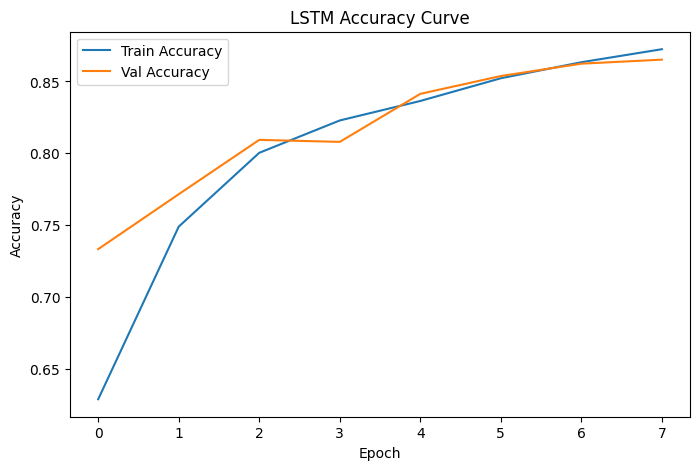

In [ ]:
def plot_history(lstm_history, LSTM):
    "Plot training history for accuracy and loss"
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))

    # Accuracy plotting
    ax1.plot(lstm_history.history['accuracy'], label='Train Accuracy')
    ax1.plot(lstm_history.history['val_accuracy'], label='Val Accuracy')
    ax1.set_title(f'{LSTM} Accuracy Curve')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend()

    plt.show()

# Plot training histories
plot_history(lstm_history, 'LSTM')

# **Convolutional Neural Network**

In [ ]:
def build_cnn_model():
    model = Sequential([
        Embedding(input_dim=max_words,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  input_length=max_length,
                  trainable=False),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])
    return model

In [ ]:
# Initializing the cnn model
cnn_model = build_cnn_model()

In [ ]:
print("CNN Model Summary")
cnn_model.summary()

CNN Model Summary


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

# **CNN Training**

In [ ]:
# Training parameters of CNN
batch_size = 128
epochs = 8
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
cnn_model = Sequential([
    Embedding(input_dim=max_words,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  input_length=max_length,
                  trainable=False),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),

    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [ ]:
# Compiling the model
cnn_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0003),
    metrics=['accuracy', 'Precision', 'Recall']
)

In [ ]:
# Training CNN model
print("Training CNN Model")
cnn_history = cnn_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Training CNN Model
Epoch 1/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 196ms/step - Precision: 0.5170 - Recall: 0.5019 - accuracy: 0.5197 - loss: 0.7212 - val_Precision: 0.6819 - val_Recall: 0.7234 - val_accuracy: 0.6892 - val_loss: 0.6135
Epoch 2/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 43s 211ms/step - Precision: 0.6690 - Recall: 0.6636 - accuracy: 0.6696 - loss: 0.6063 - val_Precision: 0.7696 - val_Recall: 0.8009 - val_accuracy: 0.7778 - val_loss: 0.4868
Epoch 3/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 203ms/step - Precision: 0.7551 - Recall: 0.7531 - accuracy: 0.7560 - loss: 0.5098 - val_Precision: 0.8179 - val_Recall: 0.7665 - val_accuracy: 0.7954 - val_loss: 0.4501
Epoch 4/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 196ms/step - Precision: 0.7819 - Recall: 0.7796 - accuracy: 0.7823 - loss: 0.4642 - val_Precision: 0.8478 - val_Recall: 0.7570 - val_accuracy: 0.8082 - val_loss: 0.4309
Epoch 5/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - Precision: 0.8019 - Recall: 0.8038 - accuracy: 0.8038 - loss: 0.4323 - val_Pr

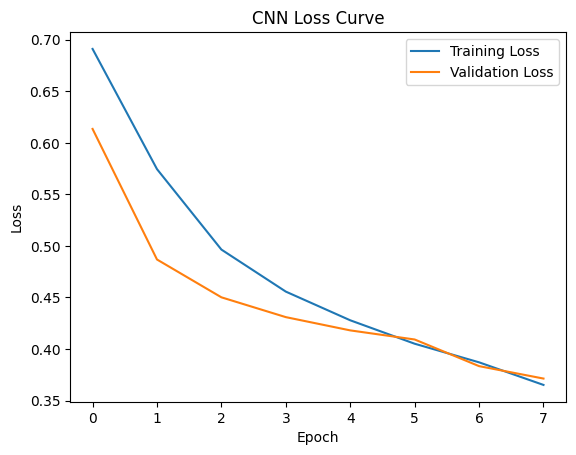

In [ ]:
# Plotting loss curve for CNN
def plot_loss_curve(cnn_history):
    plt.plot(cnn_history.history['loss'], label="Training Loss")
    plt.plot(cnn_history.history['val_loss'], label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('CNN Loss Curve')
    plt.legend()
    plt.show()

plot_loss_curve(cnn_history)

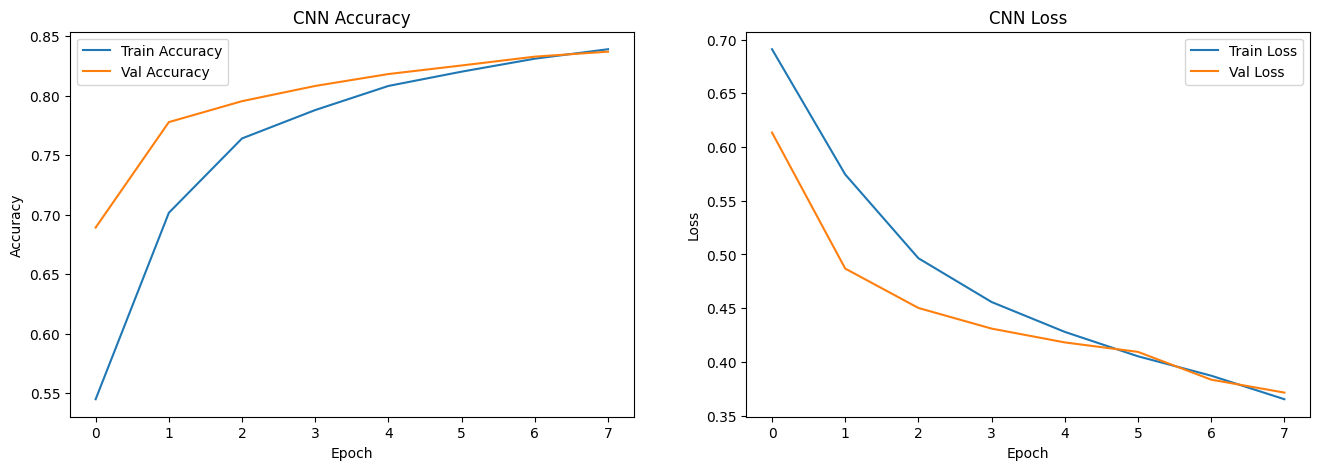

In [ ]:
def plot_history(cnn_history, CNN):
    "Plot training history for loss"
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5)) # Modified to return two axes objects

    # Accuracy plot
    ax1.plot(cnn_history.history['accuracy'], label='Train Accuracy')
    ax1.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
    ax1.set_title(f'{CNN} Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend()

    # Loss plot
    ax2.plot(cnn_history.history['loss'], label='Train Loss')
    ax2.plot(cnn_history.history['val_loss'], label='Val Loss')
    ax2.set_title(f'{CNN} Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()

    plt.show()

plot_history(cnn_history, 'CNN')

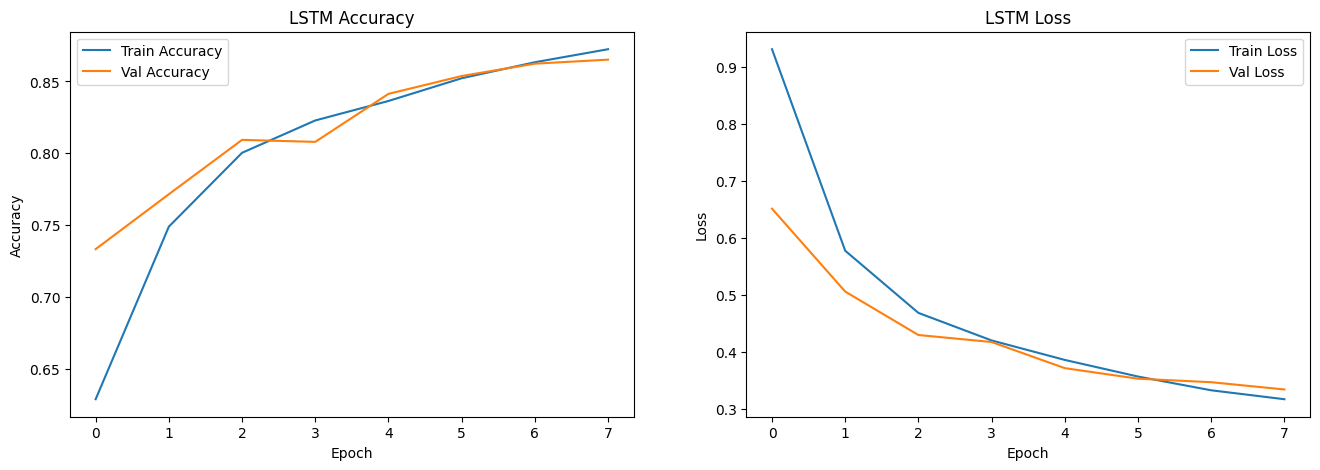

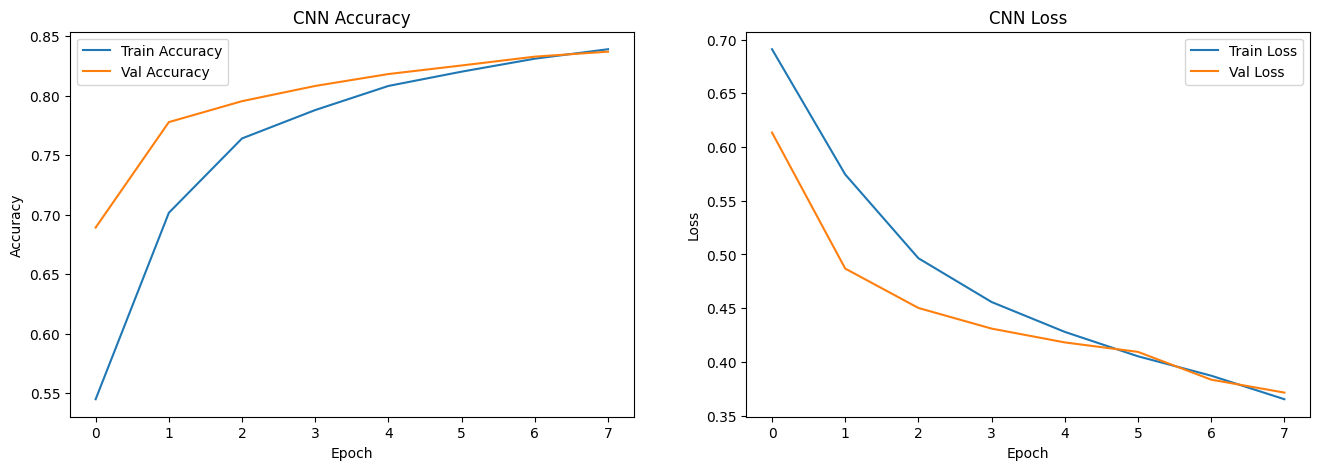

In [ ]:
# Plotting the training histories
plot_history(lstm_history, 'LSTM')
plot_history(cnn_history, 'CNN')

def evaluate_model(model, X_test, y_test, LSTM):
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    y_pred = y_pred.reshape(-1)

    print(f"\n{LSTM} Classification Report")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'{LSTM} Confusion Matrix')
    plt.show()

782/782 ━━━━━━━━━━━━━━━━━━━━ 45s 57ms/step

LSTM Classification Report
              precision    recall  f1-score   support

           0       0.86      0.88      0.87     12500
           1       0.87      0.85      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



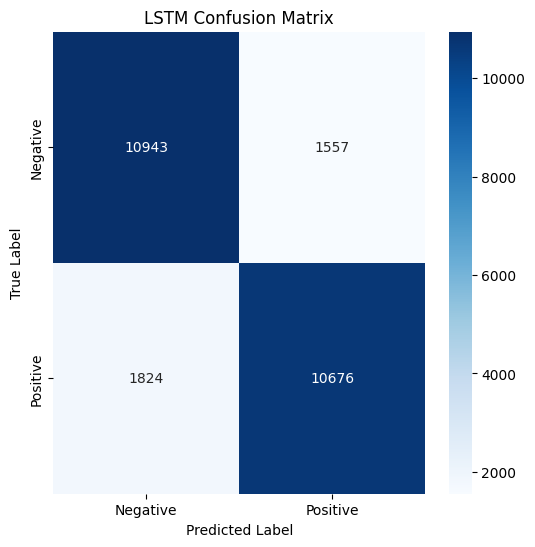

In [ ]:
evaluate_model(lstm_model, X_test, y_test, 'LSTM')

782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step

CNN Classification Report
              precision    recall  f1-score   support

           0       0.80      0.90      0.85     12500
           1       0.89      0.77      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



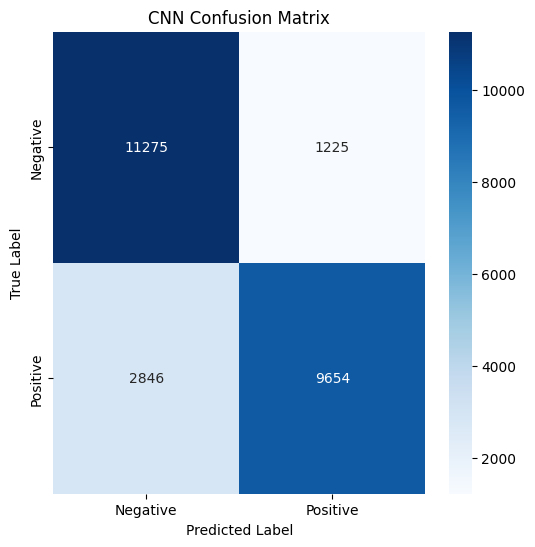

In [ ]:
evaluate_model(cnn_model, X_test, y_test, 'CNN')

782/782 ━━━━━━━━━━━━━━━━━━━━ 45s 58ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step


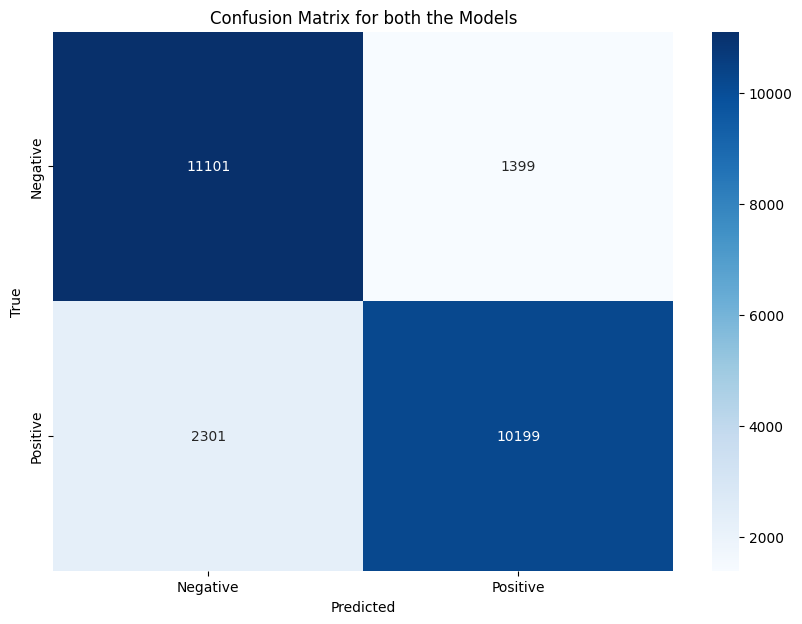

In [ ]:
def plot_confusion_matrix(true_labels, pred_labels, classes, title='Confusion Matrix for both the Models'):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()


# Getting predictions from both the models
lstm_pred = (lstm_model.predict(X_test) > 0.5).astype(int)
lstm_pred = lstm_pred.reshape(-1)

cnn_pred = (cnn_model.predict(X_test) > 0.5).astype(int)
cnn_pred = cnn_pred.reshape(-1)

combined_pred = np.zeros_like(lstm_pred) # Initialize an empty array
disagreement_indices = np.where(lstm_pred != cnn_pred)[0]

# For disagreements, randomly choose from lstm_pred or cnn_pred
for i in disagreement_indices:
    combined_pred[i] = np.random.choice([lstm_pred[i], cnn_pred[i]])
# For agreements, use the agreed-upon prediction
combined_pred[np.where(lstm_pred == cnn_pred)] = lstm_pred[np.where(lstm_pred == cnn_pred)]


# Plot the confusion matrix for both the models
plot_confusion_matrix(y_test, combined_pred, ['Negative', 'Positive'])

782/782 ━━━━━━━━━━━━━━━━━━━━ 45s 58ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step


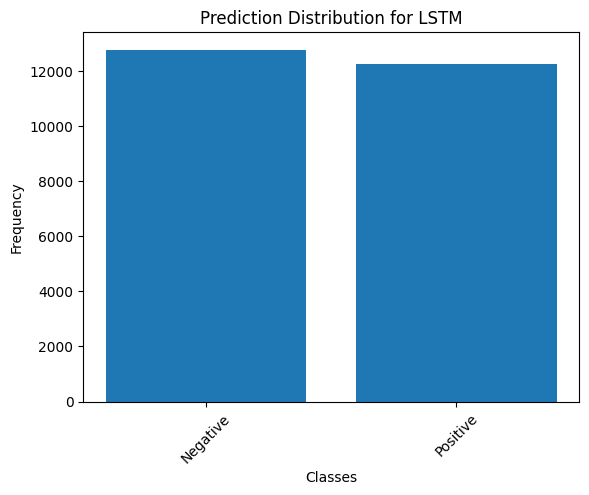

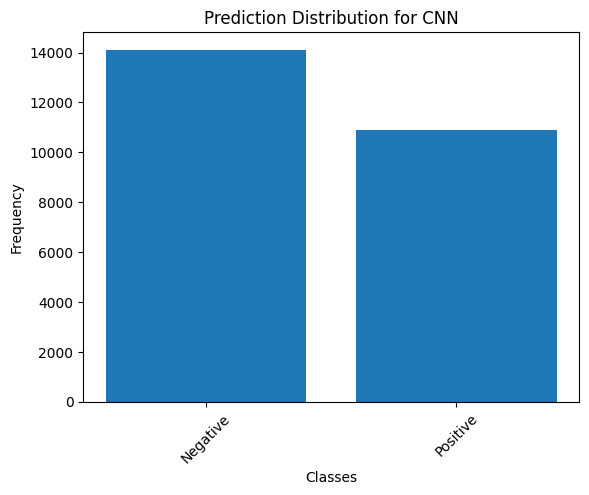

In [ ]:
def plot_predictions_distribution(pred_labels, class_names, model_name):
    unique, counts = np.unique(pred_labels, return_counts=True)
    plt.bar(unique, counts)
    plt.xticks(unique, class_names, rotation=45)
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.title(f'Prediction Distribution for {model_name}')
    plt.show()

# Get predictions from both models Bidirectional LSTM and CNN
lstm_pred = (lstm_model.predict(X_test) > 0.5).astype(int)
lstm_pred = lstm_pred.reshape(-1)

cnn_pred = (cnn_model.predict(X_test) > 0.5).astype(int)
cnn_pred = cnn_pred.reshape(-1)

plot_predictions_distribution(lstm_pred, ['Negative', 'Positive'], 'LSTM')
plot_predictions_distribution(cnn_pred, ['Negative', 'Positive'], 'CNN')

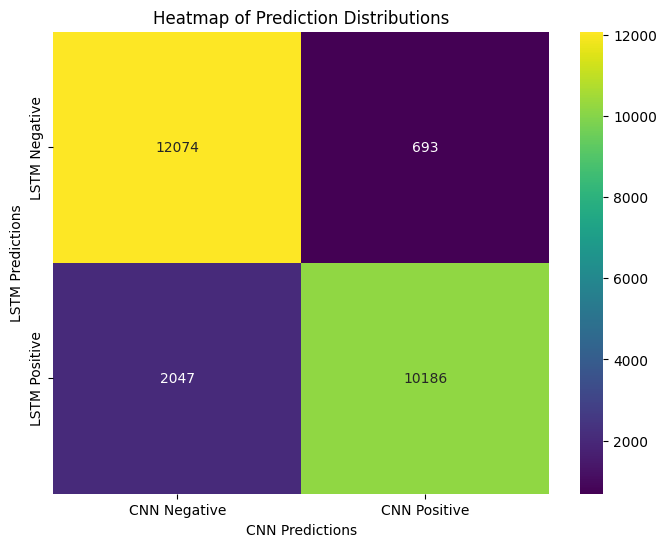

In [ ]:
# heat map
heatmap_data = confusion_matrix(lstm_pred, cnn_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='viridis',
            xticklabels=['CNN Negative', 'CNN Positive'],
            yticklabels=['LSTM Negative', 'LSTM Positive'])
plt.title('Heatmap of Prediction Distributions')
plt.xlabel('CNN Predictions')
plt.ylabel('LSTM Predictions')
plt.show()

In [ ]:
# 8. Error Analysis
def show_errors(model, X_test, y_test, num_errors=5):
    # Display misclassified examples
    predictions = model.predict(X_test)
    incorrect_indices = np.where((predictions.flatten() > 0.5) != y_test)[0]

    print(f"\nShowing {num_errors} misclassified examples ======>")
    for i in incorrect_indices[:num_errors]:
        actual = 'Positive' if y_test.iloc[i] else 'Negative'
        predicted = 'Positive' if predictions[i] > 0.5 else 'Negative'
        print(f"\nReview: {test_df.iloc[i]['review'][:200]}...")
        print(f"Actual=> {actual} || Predicted=> {predicted}")
        print(f"Confidence=> {predictions[i][0]:.2%}")

In [ ]:
# Analyze errors for LSTM model
show_errors(lstm_model, X_test, y_test)
# Analyze errors for CNN model
show_errors(cnn_model, X_test, y_test)

# Saving both the models
lstm_model.save('sentiment_lstm.keras')
cnn_model.save('sentiment_cnn.keras')

782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step

Showing 5 misclassified examples ======>

Review: As long as you keep in mind that the production of this movie was a copyright ploy, and not intended as a serious release, it is actually surprising how not absolutely horrible it is. I even liked the...
Actual=> Negative || Predicted=> Positive
Confidence=> 85.12%

Review: I saw this movie as part of a Billy Graham program. The church I attend was part of a community wide outreach to present God and Christianity to our community (Hartford, Ct. USA). I was one of the cou...
Actual=> Negative || Predicted=> Positive
Confidence=> 56.27%

Review: This classic has so many great one-liners and unintentionally hilarious scenes that I don't even know where to start. If you want advice on dating, its here. Just totally ignore the person you want, a...
Actual=> Positive || Predicted=> Negative
Confidence=> 46.07%

Review: as a former TV editor, I can say this is as authentic as it gets. It even led to 